# Import modules

In [2]:
import cifar10 as cf # my own lib to process the cifar-10 dataset
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
import os, sys
import tarfile, gzip, pickle
import tensorflow as tf
import tensorlayer as tl
import time
from IPython.display import display, Image
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

In [11]:
from imp import reload

In [12]:
reload(cf)

<module 'cifar10' from '/home/tennant/workspace/cifar10.py'>

In [3]:
%matplotlib inline

# Load the CIFAR-10 dataset

In [4]:
(X_train, y_train), (X_val, y_val), (X_test, y_test) = cf.cifar10_data_split('CIFAR10/', val=True)

Started Loading data
Finishied loading data
Prepare train, validation and test data (val = True)
Done!


In [5]:
print('train data shape: ')
print('X_train.shape: ', X_train.shape, '\ny_train.shape: ', y_train.shape)
print('validation data shape: ')
print('X_val.shape: ', X_val.shape, '\ny_val.shape: ', y_val.shape)
print('test data shape: ')
print('X_test.shape: ', X_test.shape, '\ny_test.shape: ', y_test.shape)

train data shape: 
X_train.shape:  (50000, 3072) 
y_train.shape:  (50000, 10)
validation data shape: 
X_val.shape:  (5000, 3072) 
y_val.shape:  (5000, 10)
test data shape: 
X_test.shape:  (5000, 3072) 
y_test.shape:  (5000, 10)


## Reshape the data

In [6]:
image_size = (32)
num_channel = 3

X_train = cf.prepare_data_batch(X_train)
print('X_train.shape: ', X_train.shape)
X_val = cf.prepare_data_batch(X_val)
print('X_val.shape: ', X_val.shape)
X_test = cf.prepare_data_batch(X_test)
print('X_test.shape: ', X_test.shape)

X_train.shape:  (50000, 32, 32, 3)
X_val.shape:  (5000, 32, 32, 3)
X_test.shape:  (5000, 32, 32, 3)


## Display a random image for sanity check

(32, 32, 3)


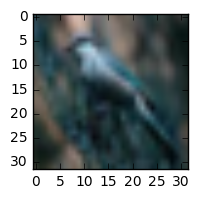

In [7]:
sample_idx = np.random.randint(len(X_train))
sample_img = X_train[sample_idx, :]
print(sample_img.shape)
plt.rcParams['figure.figsize'] = (2.0, 8.0)
plt.figure()
plt.imshow(sample_img.astype('uint8'))

# Set up and run the models

## Parameters

In [8]:
np.random.seed(42)

#General hyper-parmeters
n_epoch = 100
batch_size = 64

#Adam Optimizer
#m = beta1*m + (1‐beta1)*dx
#v = beta2*v + (1‐beta2)*(dx**2)
#x += ‐ learning_rate * m / (np.sqrt(v) + eps)
learning_rate = 0.001 
learning_rate_l2 = 0.0005
beta1_adam = 0.9
beta2_adam = 0.999
eps_adam = 1e-8 

#Conv layers hyper-parameters
patch_size = 5
depth = 10

#Dense/drop layers hyper-parameters
#num_hidden1 = 64
num_hidden1 = 256
#num_hidden2 = 32
num_hidden2 = 64
keep_prob = 0.5

#L2
l2_reg = 0.08

#Constant parameters
im_height = 32
im_width = 32
num_classes = y_train.shape[1]
print_freq = 10

In [9]:
#reset the compute graph
tf.reset_default_graph()

In [10]:
count = 1

In [11]:
#Convert to an array
X_train = np.asarray(X_train, dtype=np.float32)
y_train = np.asarray(y_train, dtype=np.int64)
X_val = np.asarray(X_val, dtype=np.float32)
y_val = np.asarray(y_val, dtype=np.int64)
X_test = np.asarray(X_test, dtype=np.float32)
y_test = np.asarray(y_test, dtype=np.int64)

print('X_train.shape', X_train.shape)
print('y_train.shape', y_train.shape)
print('X_val.shape', X_val.shape)
print('y_val.shape', y_val.shape)
print('X_test.shape', X_test.shape)
print('y_test.shape', y_test.shape)

X_train.shape (50000, 32, 32, 3)
y_train.shape (50000, 10)
X_val.shape (5000, 32, 32, 3)
y_val.shape (5000, 10)
X_test.shape (5000, 32, 32, 3)
y_test.shape (5000, 10)


### Baseline: No regulations, 2xCNN-Feature Extractor / 2x Fully Connected Layer / 1x Softmax Layer

#### Model define

In [11]:
count += 1
sess = tf.InteractiveSession()

X = tf.placeholder(tf.float32, shape=[batch_size, im_height, im_width, num_channel])
y = tf.placeholder(tf.int64, shape=[batch_size, num_classes])

network = tl.layers.InputLayer(X, name='input_layer_noreg' + str(count))
network = tl.layers.Conv2dLayer(network, act=tf.nn.relu, W_init=tf.truncated_normal_initializer(stddev=0.1),
                               shape=[patch_size, patch_size, num_channel, depth], strides=[1, 2, 2, 1],
                               padding='SAME', name='cnn_layer1_noreg' + str(count))
network = tl.layers.Conv2dLayer(network, act=tf.nn.relu, W_init=tf.truncated_normal_initializer(stddev=0.1),
                               shape=[patch_size, patch_size, depth, depth], strides=[1, 2, 2, 1],
                               padding='SAME', name='cnn_layer2_noreg' + str(count))
network = tl.layers.FlattenLayer(network, name='flatten_layer_noreg' + str(count))
network = tl.layers.DenseLayer(network, n_units=num_hidden1, act=tf.nn.relu, 
                              W_init=tf.truncated_normal_initializer(stddev=0.1),
                              name='dense_layer1_noreg' + str(count))
network = tl.layers.DenseLayer(network, n_units=num_hidden2, act=tf.nn.relu,
                              W_init=tf.truncated_normal_initializer(stddev=0.1),
                              name='dense_layer2_noreg' + str(count))
network = tl.layers.DenseLayer(network, n_units=num_classes, act=tf.identity,
                              W_init=tf.truncated_normal_initializer(stddev=0.1),
                              name='output_layer_noreg' + str(count))
pred_y = network.outputs

#compute the loss and accuracy
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred_y, labels=y))
correct_pred = tf.equal(tf.argmax(pred_y, 1), tf.argmax(y, 1))
acc = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

train_param = network.all_params
train_op = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1_adam, beta2=beta2_adam,
                                 epsilon=eps_adam, use_locking=False).minimize(loss, var_list=train_param)

  [TL] InputLayer  input_layer_noreg2: (64, 32, 32, 3)
  [TL] Conv2dLayer cnn_layer1_noreg2: shape:[5, 5, 3, 10] strides:[1, 2, 2, 1] pad:SAME act:relu
  [TL] Conv2dLayer cnn_layer2_noreg2: shape:[5, 5, 10, 10] strides:[1, 2, 2, 1] pad:SAME act:relu
  [TL] FlattenLayer flatten_layer_noreg2: 640
  [TL] DenseLayer  dense_layer1_noreg2: 256 relu
  [TL] DenseLayer  dense_layer2_noreg2: 64 relu
  [TL] DenseLayer  output_layer_noreg2: 10 identity


#### Log define

In [12]:
loss_hist_noreg = np.zeros(n_epoch)
train_pred_acc_noreg = np.zeros(n_epoch)
val_hist_noreg = np.zeros(n_epoch)
val_pred_acc_noreg = np.zeros(n_epoch)

#### Training

In [13]:
start_time = time.time()
print('Start Training at ', time.asctime(time.localtime(start_time)))
sess.run(tf.global_variables_initializer())

for epoch in range(n_epoch):
    for X_batch, y_batch in tl.iterate.minibatches(X_train, y_train, batch_size, shuffle=True):
        sess.run(train_op, feed_dict={X: X_batch, y: y_batch})
    print("Epoch %d of %d" % (epoch + 1, n_epoch))
    
    #training log
    train_loss, train_acc, n_batch = 0, 0, 0
    for X_batch, y_batch in tl.iterate.minibatches(X_train, y_train, batch_size, shuffle=True):
        loss_, acc_ = sess.run([loss, acc], feed_dict={X: X_batch, y: y_batch})
        train_loss += loss_; train_acc += acc_; n_batch += 1
    loss_hist_noreg[epoch] = train_loss / n_batch
    train_pred_acc_noreg[epoch] = train_acc / n_batch
    
    #val log
    val_loss, val_acc, n_batch = 0, 0, 0
    for X_batch, y_batch in tl.iterate.minibatches(X_val, y_val, batch_size, shuffle=True):
        loss_, acc_ = sess.run([loss, acc], feed_dict={X: X_batch, y: y_batch})
        val_loss += loss_; val_acc += acc_; n_batch += 1
    val_hist_noreg[epoch] = val_loss / n_batch
    val_pred_acc_noreg[epoch] = val_acc / n_batch
    
    #print log
    if (epoch + 1) % print_freq == 0:
        print('Training loss: %.3f' % loss_hist_noreg[epoch])
        print('Training accuracy: %.3f' % train_pred_acc_noreg[epoch])
        print('Validation loss: %.3f' % val_hist_noreg[epoch])
        print('Validation accuracy: %.3f' % val_pred_acc_noreg[epoch])

end_time = time.time()
print('Training takes: %d seconds' % (end_time - start_time))

Start Training at  Sun Feb 25 11:40:12 2018
Epoch 1 of 100
Epoch 2 of 100
Epoch 3 of 100
Epoch 4 of 100
Epoch 5 of 100
Epoch 6 of 100
Epoch 7 of 100
Epoch 8 of 100
Epoch 9 of 100
Epoch 10 of 100
Training loss: 0.781
Training accuracy: 0.718
Validation loss: 1.532
Validation accuracy: 0.514
Epoch 11 of 100
Epoch 12 of 100
Epoch 13 of 100
Epoch 14 of 100
Epoch 15 of 100
Epoch 16 of 100
Epoch 17 of 100
Epoch 18 of 100
Epoch 19 of 100
Epoch 20 of 100
Training loss: 0.353
Training accuracy: 0.874
Validation loss: 2.830
Validation accuracy: 0.486
Epoch 21 of 100
Epoch 22 of 100
Epoch 23 of 100
Epoch 24 of 100
Epoch 25 of 100
Epoch 26 of 100
Epoch 27 of 100
Epoch 28 of 100
Epoch 29 of 100
Epoch 30 of 100
Training loss: 0.243
Training accuracy: 0.915
Validation loss: 3.786
Validation accuracy: 0.479
Epoch 31 of 100
Epoch 32 of 100
Epoch 33 of 100
Epoch 34 of 100
Epoch 35 of 100
Epoch 36 of 100
Epoch 37 of 100
Epoch 38 of 100
Epoch 39 of 100
Epoch 40 of 100
Training loss: 0.184
Training accurac

#### Test

In [14]:
print('Test')

test_loss, test_acc, n_batch = 0, 0, 0
for X_batch, y_batch in tl.iterate.minibatches(X_test, y_test, batch_size, shuffle=True):
    loss_, acc_ = sess.run([loss, acc], feed_dict={X: X_batch, y: y_batch})
    test_loss += loss_; test_acc += acc_; n_batch += 1
test_loss_noreg = test_loss / n_batch
test_acc_noreg = test_acc / n_batch

print('Test loss: %.3f' % test_loss_noreg)
print('Test acc: %.3f' % test_acc_noreg)

Test
Test loss: 7.973
Test acc: 0.459


#### Plot the loss and accuracy graph

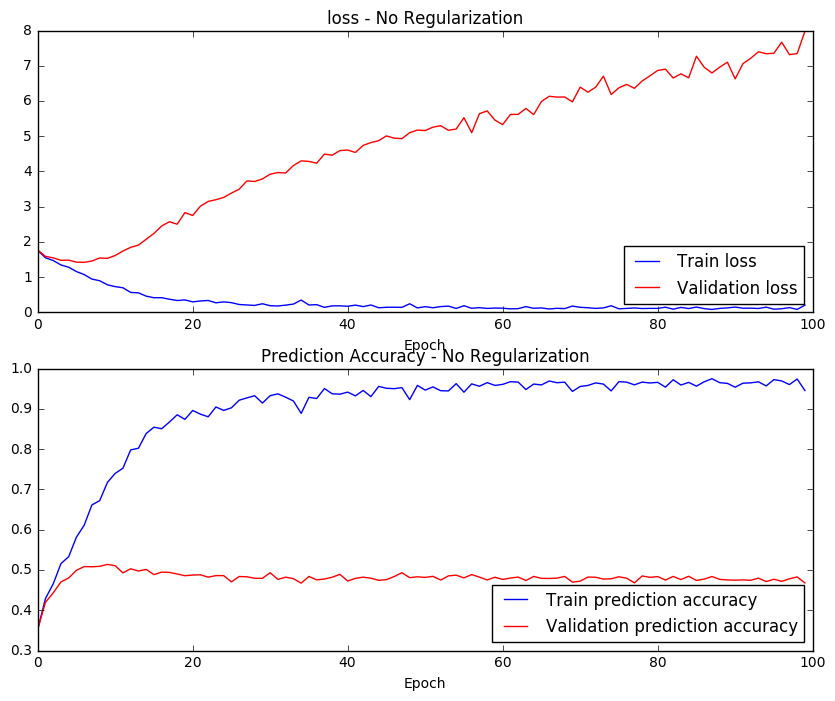

In [15]:
plt.rcParams['figure.figsize'] = (10.0, 8.0) 
plt.subplot(2,1,1)
plt.plot(loss_hist_noreg, 'b')
plt.plot(val_hist_noreg, 'r')

plt.title('loss - No Regularization')
plt.xlabel('Epoch')

plt.legend(['Train loss', 'Validation loss'], loc=4)

plt.subplot(2,1,2)
plt.plot(train_pred_acc_noreg, 'b')
plt.plot(val_pred_acc_noreg, 'r')

plt.title('Prediction Accuracy - No Regularization')
plt.xlabel('Epoch')

plt.legend(['Train prediction accuracy' ,'Validation prediction accuracy'], loc=4)
plt.show()

#### visualize the network

In [16]:
## Save Network for Visualization
# L5
w = network.all_params[8].eval() # Done once per notebook
w_size = np.int(np.round(np.sqrt(w.shape[0])))
w_5_noreg = w.reshape(w_size, w_size, num_classes)

# L4
w = network.all_params[6].eval() # Done once per notebook
w_4_noreg = w.reshape(w.shape[0], w.shape[1])

# L3
w = network.all_params[4].eval() # Done once per notebook
w_3_noreg = w.reshape(w.shape[0], w.shape[1])

# L2
w = network.all_params[2].eval() # Done once per notebook
w_2_noreg = w.reshape(w.shape[0], w.shape[1], w.shape[2], w.shape[3])

# L1
w = network.all_params[0].eval() # Done once per notebook
w_1_noreg = w.reshape(w.shape[0], w.shape[1], w.shape[2], w.shape[3])

In [21]:
#remove the previous network for the new one
del network

NameError: name 'network' is not defined

### L2 regularization: 2xCNN-Feature Extractor / 2x Fully Connected Layer / 1x Softmax Layer

#### model define 

In [18]:
count += 1
sess = tf.InteractiveSession()

X = tf.placeholder(tf.float32, shape=[batch_size, im_height, im_width, num_channel])
y = tf.placeholder(tf.int64, shape=[batch_size, num_classes])

network = tl.layers.InputLayer(X, name='input_layer_l2reg' + str(count))
network = tl.layers.Conv2dLayer(network, act=tf.nn.relu, W_init=tf.truncated_normal_initializer(stddev=0.1),
                               shape=[patch_size, patch_size, num_channel, depth], strides=[1, 2, 2, 1],
                               padding='SAME', name='cnn_layer1_l2reg' + str(count))
network = tl.layers.Conv2dLayer(network, act=tf.nn.relu, W_init=tf.truncated_normal_initializer(stddev=0.1),
                               shape=[patch_size, patch_size, depth, depth], strides=[1, 2, 2, 1],
                               padding='SAME', name='cnn_layer2_l2reg' + str(count))
network = tl.layers.FlattenLayer(network, name='flatten_layer_l2reg' + str(count))
network = tl.layers.DenseLayer(network, n_units=num_hidden1, act=tf.nn.relu, 
                              W_init=tf.truncated_normal_initializer(stddev=0.1),
                              name='dense_layer1_l2reg' + str(count))
network = tl.layers.DenseLayer(network, n_units=num_hidden2, act=tf.nn.relu,
                              W_init=tf.truncated_normal_initializer(stddev=0.1),
                              name='dense_layer2_l2reg' + str(count))
network = tl.layers.DenseLayer(network, n_units=num_classes, act=tf.identity,
                              W_init=tf.truncated_normal_initializer(stddev=0.1),
                              name='output_layer_l2reg' + str(count))
pred_y = network.outputs

#compute the loss and accuracy
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred_y, labels=y))
l2_loss = tf.contrib.layers.l2_regularizer(l2_reg)(network.all_params[4]) + \
                    tf.contrib.layers.l2_regularizer(l2_reg)(network.all_params[6])
loss = loss + l2_loss
correct_pred = tf.equal(tf.argmax(pred_y, 1), tf.argmax(y, 1))
acc = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

train_param = network.all_params
train_op = tf.train.AdamOptimizer(learning_rate=learning_rate_l2, beta1=beta1_adam, beta2=beta2_adam,
                                 epsilon=eps_adam, use_locking=False).minimize(loss, var_list=train_param)

  [TL] InputLayer  input_layer_l2reg3: (64, 32, 32, 3)
  [TL] Conv2dLayer cnn_layer1_l2reg3: shape:[5, 5, 3, 10] strides:[1, 2, 2, 1] pad:SAME act:relu
  [TL] Conv2dLayer cnn_layer2_l2reg3: shape:[5, 5, 10, 10] strides:[1, 2, 2, 1] pad:SAME act:relu
  [TL] FlattenLayer flatten_layer_l2reg3: 640
  [TL] DenseLayer  dense_layer1_l2reg3: 256 relu
  [TL] DenseLayer  dense_layer2_l2reg3: 64 relu
  [TL] DenseLayer  output_layer_l2reg3: 10 identity


#### Log define

In [19]:
loss_hist_l2reg = np.zeros(n_epoch)
train_pred_acc_l2reg = np.zeros(n_epoch)
val_hist_l2reg = np.zeros(n_epoch)
val_pred_acc_l2reg = np.zeros(n_epoch)

#### Training

In [20]:
start_time = time.time()
print('Start Training at ', time.asctime(time.localtime(start_time)))
sess.run(tf.global_variables_initializer())

for epoch in range(n_epoch):
    for X_batch, y_batch in tl.iterate.minibatches(X_train, y_train, batch_size, shuffle=True):
        sess.run(train_op, feed_dict={X: X_batch, y: y_batch})
    print("Epoch %d of %d" % (epoch + 1, n_epoch))
    
    #training log
    train_loss, train_acc, n_batch = 0, 0, 0
    for X_batch, y_batch in tl.iterate.minibatches(X_train, y_train, batch_size, shuffle=True):
        loss_, acc_ = sess.run([loss, acc], feed_dict={X: X_batch, y: y_batch})
        train_loss += loss_; train_acc += acc_; n_batch += 1
    loss_hist_l2reg[epoch] = train_loss / n_batch
    train_pred_acc_l2reg[epoch] = train_acc / n_batch
    
    #val log
    val_loss, val_acc, n_batch = 0, 0, 0
    for X_batch, y_batch in tl.iterate.minibatches(X_val, y_val, batch_size, shuffle=True):
        loss_, acc_ = sess.run([loss, acc], feed_dict={X: X_batch, y: y_batch})
        val_loss += loss_; val_acc += acc_; n_batch += 1
    val_hist_l2reg[epoch] = val_loss / n_batch
    val_pred_acc_l2reg[epoch] = val_acc / n_batch
    
    #print log
    if (epoch + 1) % print_freq == 0:
        print('Training loss: %.3f' % loss_hist_l2reg[epoch])
        print('Training accuracy: %.3f' % train_pred_acc_l2reg[epoch])
        print('Validation loss: %.3f' % val_hist_l2reg[epoch])
        print('Validation accuracy: %.3f' % val_pred_acc_l2reg[epoch])

end_time = time.time()
print('Training takes: %d seconds' % (end_time - start_time))

Start Training at  Sun Feb 25 12:30:45 2018
Epoch 1 of 100
Epoch 2 of 100
Epoch 3 of 100
Epoch 4 of 100
Epoch 5 of 100
Epoch 6 of 100
Epoch 7 of 100
Epoch 8 of 100
Epoch 9 of 100
Epoch 10 of 100
Training loss: 1.401
Training accuracy: 0.551
Validation loss: 1.459
Validation accuracy: 0.530
Epoch 11 of 100
Epoch 12 of 100
Epoch 13 of 100
Epoch 14 of 100
Epoch 15 of 100
Epoch 16 of 100
Epoch 17 of 100
Epoch 18 of 100
Epoch 19 of 100
Epoch 20 of 100
Training loss: 1.224
Training accuracy: 0.621
Validation loss: 1.356
Validation accuracy: 0.574
Epoch 21 of 100
Epoch 22 of 100
Epoch 23 of 100
Epoch 24 of 100
Epoch 25 of 100
Epoch 26 of 100
Epoch 27 of 100
Epoch 28 of 100
Epoch 29 of 100
Epoch 30 of 100
Training loss: 1.102
Training accuracy: 0.669
Validation loss: 1.255
Validation accuracy: 0.617
Epoch 31 of 100
Epoch 32 of 100
Epoch 33 of 100
Epoch 34 of 100
Epoch 35 of 100
Epoch 36 of 100
Epoch 37 of 100
Epoch 38 of 100
Epoch 39 of 100
Epoch 40 of 100
Training loss: 1.066
Training accurac

#### Test

In [21]:
print('Test')

test_loss, test_acc, n_batch = 0, 0, 0
for X_batch, y_batch in tl.iterate.minibatches(X_test, y_test, batch_size, shuffle=True):
    loss_, acc_ = sess.run([loss, acc], feed_dict={X: X_batch, y: y_batch})
    test_loss += loss_; test_acc += acc_; n_batch += 1
test_loss_l2reg = test_loss / n_batch
test_acc_l2reg = test_acc / n_batch

print('Test loss: %.3f' % test_loss_l2reg)
print('Test acc: %.3f' % test_acc_l2reg)

Test
Test loss: 1.248
Test acc: 0.627


#### Plot the loss and accuracy graph

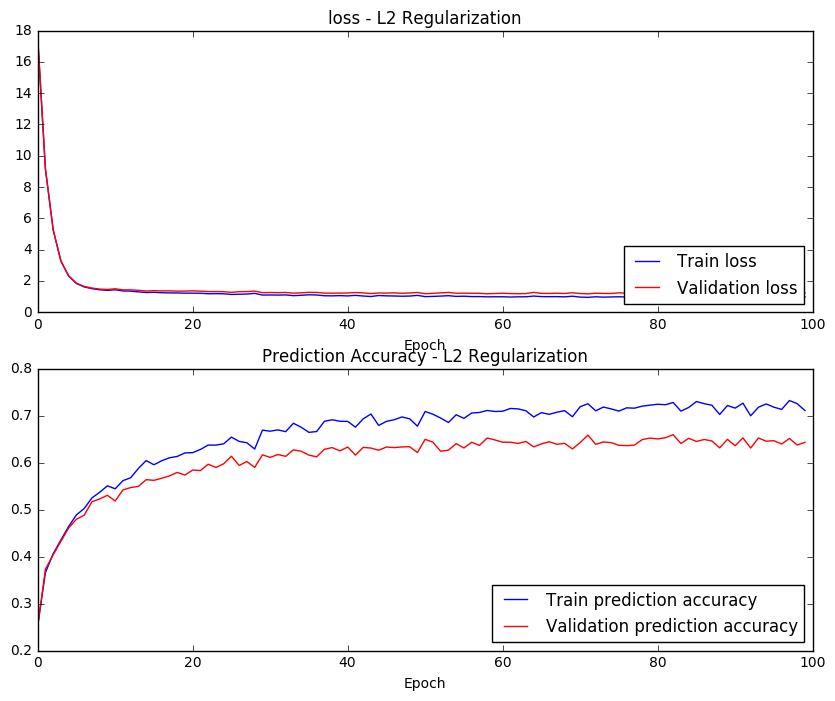

In [22]:
plt.rcParams['figure.figsize'] = (10.0, 8.0) 
plt.subplot(2,1,1)
plt.plot(loss_hist_l2reg, 'b')
plt.plot(val_hist_l2reg, 'r')

plt.title('loss - L2 Regularization')
plt.xlabel('Epoch')

plt.legend(['Train loss', 'Validation loss'], loc=4)

plt.subplot(2,1,2)
plt.plot(train_pred_acc_l2reg, 'b')
plt.plot(val_pred_acc_l2reg, 'r')

plt.title('Prediction Accuracy - L2 Regularization')
plt.xlabel('Epoch')

plt.legend(['Train prediction accuracy' ,'Validation prediction accuracy'], loc=4)
plt.show()

#### visualize the network

In [23]:
## Save Network for Visualization
# L5
w = network.all_params[8].eval() # Done once per notebook
w_size = np.int(np.round(np.sqrt(w.shape[0])))
w_5_l2 = w.reshape(w_size, w_size, num_classes)

# L4
w = network.all_params[6].eval() # Done once per notebook
w_4_l2 = w.reshape(w.shape[0], w.shape[1])

# L3
w = network.all_params[4].eval() # Done once per notebook
w_3_l2 = w.reshape(w.shape[0], w.shape[1])

# L2
w = network.all_params[2].eval() # Done once per notebook
w_2_l2 = w.reshape(w.shape[0], w.shape[1], w.shape[2], w.shape[3])

# L1
w = network.all_params[0].eval() # Done once per notebook
w_1_l2 = w.reshape(w.shape[0], w.shape[1], w.shape[2], w.shape[3])

In [24]:
del network

## Analysis of L2 and L1 regularization

### Parameter estimation from frequentist point of view

The CNN's training process can be seen as a process that tries to find the optimal value of the Network's Parameters, then we can introduce the idea of **Maximum Likelihood Estimation**, a.k.a *MLE*, which can be seen as a method that tries to find the estimation of the Network's parameters $\theta$, this can be defined as follows:
$$\theta_{MLE}=argmax\;P(data|\theta)=argmax\;P(x_1|\theta)P(x_2|\theta)\dots\;P(x_n|\theta)=argmax\;\prod^{n}_{i=1}P(x_i|\theta)$$
take $log$ on both side, and multiply it by $-1$, we get:
$$\theta_{MLE}=argmin\;-\sum^{n}_{i=1}log\;P(x_i|\theta)$$
This is called the Negative Log Likelihood function(NLL), you should have noticed that this is very similar to the cross-entropy loss function we used in NNs!

### Parameter estimation from Bayes point of view

Bayesian School uses **Maximum A Posterior**, a.k.a *MAP*, to estimate the parameters of NNs, which is:
$$\theta_{MAP}=argmax\;P(\theta|data)$$
also, we take $log$ on both side, and then multiply it by $-1$, we get:
$$\theta_{MAP}=argmin\;log\;P(\theta|data)$$
We also know the famous Bayes fomula:
$$P(\theta|data)=\frac{P(data|\theta)\times P(\theta)}{P(data)}$$
Use this fomula, we get:
$$\theta_{MAP}=argmin\;-log\;P(data|\theta)-log\;P(\theta)+log\;P(data)$$
We know that $P(data)$ is a constant, so the equation can be rewrite as:
$$\theta_{MAP}=argmin\;-log\;P(data|\theta)-log\;P(\theta)$$
The $-log\;P(data|\theta)$ is the NLL, so the main difference between MLE and MAP is the priori $-log\;P(\theta)$

### The priori $P(\theta)$'s distribution as regularization

So, what is this so called priori $P(\theta)$?
Take $P(\theta)$ from letter, you can take this as "how do you feel the parameter $\theta$ should be distributed?"
First, let's assume that the parameter subject to gaussian distribution:
$$P(\theta)\sim{e^{-\frac{\theta^2}{2\sigma^2}}}$$
Thus, the $\theta_{MAP}$ will be:
$$\theta_{MAP}=argmin\;-log\;P(data|\theta)-log\;e^{-\frac{\theta^2}{2\sigma^2}}=argmin\;-log\;P(data|\theta)+\frac{\theta^2}{2\sigma^2}$$
Notice that $\theta_{MLE}=argmin\;P(\theta|data)$, so if we choose the gaussian distribution to be the priori of MAP, then the MAP is MLE plus L2 regularization!
From this point of view, we can interprete the L2 regularization as a priori that the distribution of $P(\theta)$ is a gaussian, we can plot out the weight graph of the network to verify this.
If we choose to believe that the distribution of $P(\theta)$ is a laplacian distribution:
$$P(\theta)\sim{e^{-\frac{\left|\theta\right|}{b}}}$$
We can easily write this:
$$\theta_{MAP}=argmin\;-log\;P(data|\theta)+\frac{\left|\theta\right|}{b}$$
This is L1 regularization, this can also explain why the NN's parameter will be sparse(close to zero) when using L1 regulariztion(the laplacian distribution is sparse)

### Plot the weight graphs

### Dropout 2xCNN-Feature Extractor / 2x Fully Connected Layer / 1x Softmax Layer

#### model define

In [12]:
count += 1
sess = tf.InteractiveSession()

X = tf.placeholder(tf.float32, shape=[batch_size, im_height, im_width, num_channel], name='X' + str(count))
y = tf.placeholder(tf.int64, shape=[batch_size, num_classes], name='y' + str(count))

network = tl.layers.InputLayer(X, name='input_layer_dropout' + str(count))
network = tl.layers.Conv2dLayer(network, act=tf.nn.relu, W_init=tf.truncated_normal_initializer(stddev=0.1),
                               shape=[patch_size, patch_size, num_channel, depth], strides=[1, 2, 2, 1],
                               padding='SAME', name='cnn_layer1_dropout' + str(count))
network = tl.layers.Conv2dLayer(network, act=tf.nn.relu, W_init=tf.truncated_normal_initializer(stddev=0.1),
                               shape=[patch_size, patch_size, depth, depth], strides=[1, 2, 2, 1],
                               padding='SAME', name='cnn_layer2_dropout' + str(count))
network = tl.layers.FlattenLayer(network, name='flatten_layer_dropout' + str(count))
network = tl.layers.DropoutLayer(network, keep=keep_prob, name='dropout_layer1_dropout' + str(count))
network = tl.layers.DenseLayer(network, n_units=num_hidden1, act=tf.nn.relu, 
                              W_init=tf.truncated_normal_initializer(stddev=0.1),
                              name='dense_layer1_dropout' + str(count))
network = tl.layers.DropoutLayer(network, keep=keep_prob, name='dropout_layer2_dropout' + str(count))
network = tl.layers.DenseLayer(network, n_units=num_hidden2, act=tf.nn.relu,
                              W_init=tf.truncated_normal_initializer(stddev=0.1),
                              name='dense_layer2_dropout' + str(count))
network = tl.layers.DenseLayer(network, n_units=num_classes, act=tf.identity,
                              W_init=tf.truncated_normal_initializer(stddev=0.1),
                              name='output_layer_dropout' + str(count))
pred_y = network.outputs

#compute the loss and accuracy
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred_y, labels=y))
correct_pred = tf.equal(tf.argmax(pred_y, 1), tf.argmax(y, 1))
acc = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

train_param = network.all_params
train_op = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1_adam, beta2=beta2_adam,
                                 epsilon=eps_adam, use_locking=False).minimize(loss, var_list=train_param)

  [TL] InputLayer  input_layer_dropout2: (64, 32, 32, 3)
  [TL] Conv2dLayer cnn_layer1_dropout2: shape:[5, 5, 3, 10] strides:[1, 2, 2, 1] pad:SAME act:relu
  [TL] Conv2dLayer cnn_layer2_dropout2: shape:[5, 5, 10, 10] strides:[1, 2, 2, 1] pad:SAME act:relu
  [TL] FlattenLayer flatten_layer_dropout2: 640
  [TL] DropoutLayer dropout_layer1_dropout2: keep:0.500000 is_fix:False
  [TL] DenseLayer  dense_layer1_dropout2: 256 relu
  [TL] DropoutLayer dropout_layer2_dropout2: keep:0.500000 is_fix:False
  [TL] DenseLayer  dense_layer2_dropout2: 64 relu
  [TL] DenseLayer  output_layer_dropout2: 10 identity


#### Log define

In [13]:
loss_hist_dropout = np.zeros(n_epoch)
train_pred_acc_dropout = np.zeros(n_epoch)
val_hist_dropout = np.zeros(n_epoch)
val_pred_acc_dropout = np.zeros(n_epoch)

#### Train

In [15]:
start_time = time.time()
print('Start Training at ', time.asctime(time.localtime(start_time)))
sess.run(tf.global_variables_initializer())

for epoch in range(n_epoch):
    for X_batch, y_batch in tl.iterate.minibatches(X_train, y_train, batch_size, shuffle=True):
        feed_dict = {X: X_batch, y: y_batch}
        feed_dict.update(network.all_drop)
        sess.run(train_op, feed_dict=feed_dict)
    print("Epoch %d of %d" % (epoch + 1, n_epoch))
    
    #training log
    train_loss, train_acc, n_batch = 0, 0, 0
    for X_batch, y_batch in tl.iterate.minibatches(X_train, y_train, batch_size, shuffle=True):
        dp_dict = tl.utils.dict_to_one(network.all_drop)    
        feed_dict = {X: X_batch, y: y_batch}
        feed_dict.update(dp_dict)
        loss_, acc_ = sess.run([loss, acc], feed_dict=feed_dict)
        train_loss += loss_; train_acc += acc_; n_batch += 1
    loss_hist_dropout[epoch] = train_loss / n_batch
    train_pred_acc_dropout[epoch] = train_acc / n_batch
    
    #val log
    val_loss, val_acc, n_batch = 0, 0, 0
    for X_batch, y_batch in tl.iterate.minibatches(X_val, y_val, batch_size, shuffle=True):
        dp_dict = tl.utils.dict_to_one(network.all_drop)    
        feed_dict = {X: X_batch, y: y_batch}
        feed_dict.update(dp_dict)
        loss_, acc_ = sess.run([loss, acc], feed_dict=feed_dict)
        val_loss += loss_; val_acc += acc_; n_batch += 1
    val_hist_dropout[epoch] = val_loss / n_batch
    val_pred_acc_dropout[epoch] = val_acc / n_batch
    
    #print log
    if (epoch + 1) % print_freq == 0:
        print('Training loss: %.3f' % loss_hist_dropout[epoch])
        print('Training accuracy: %.3f' % train_pred_acc_dropout[epoch])
        print('Validation loss: %.3f' % val_hist_dropout[epoch])
        print('Validation accuracy: %.3f' % val_pred_acc_dropout[epoch])

end_time = time.time()
print('Training takes: %d seconds' % (end_time - start_time))

Start Training at  Sun Feb 25 14:53:35 2018
Epoch 1 of 100
Epoch 2 of 100
Epoch 3 of 100
Epoch 4 of 100
Epoch 5 of 100
Epoch 6 of 100
Epoch 7 of 100
Epoch 8 of 100
Epoch 9 of 100
Epoch 10 of 100
Training loss: 1.754
Training accuracy: 0.354
Validation loss: 1.755
Validation accuracy: 0.358
Epoch 11 of 100
Epoch 12 of 100
Epoch 13 of 100
Epoch 14 of 100
Epoch 15 of 100
Epoch 16 of 100
Epoch 17 of 100
Epoch 18 of 100
Epoch 19 of 100
Epoch 20 of 100
Training loss: 1.442
Training accuracy: 0.484
Validation loss: 1.474
Validation accuracy: 0.470
Epoch 21 of 100
Epoch 22 of 100
Epoch 23 of 100
Epoch 24 of 100
Epoch 25 of 100
Epoch 26 of 100
Epoch 27 of 100
Epoch 28 of 100
Epoch 29 of 100
Epoch 30 of 100
Training loss: 1.307
Training accuracy: 0.531
Validation loss: 1.351
Validation accuracy: 0.514
Epoch 31 of 100
Epoch 32 of 100
Epoch 33 of 100
Epoch 34 of 100
Epoch 35 of 100
Epoch 36 of 100
Epoch 37 of 100
Epoch 38 of 100
Epoch 39 of 100
Epoch 40 of 100
Training loss: 1.236
Training accurac

#### Test

In [16]:
print('Test')

test_loss, test_acc, n_batch = 0, 0, 0
for X_batch, y_batch in tl.iterate.minibatches(X_test, y_test, batch_size, shuffle=True):
    dp_dict = tl.utils.dict_to_one( network.all_drop )    
    feed_dict = {X: X_batch, y: y_batch}
    feed_dict.update(dp_dict)
    loss_, acc_ = sess.run([loss, acc], feed_dict=feed_dict)
    test_loss += loss_; test_acc += acc_; n_batch += 1
test_loss_dropout = test_loss / n_batch
test_acc_dropout = test_acc / n_batch

print('Test loss: %.3f' % test_loss_dropout)
print('Test acc: %.3f' % test_acc_dropout)

Test
Test loss: 1.192
Test acc: 0.582


#### Plot the loss and accuracy graph

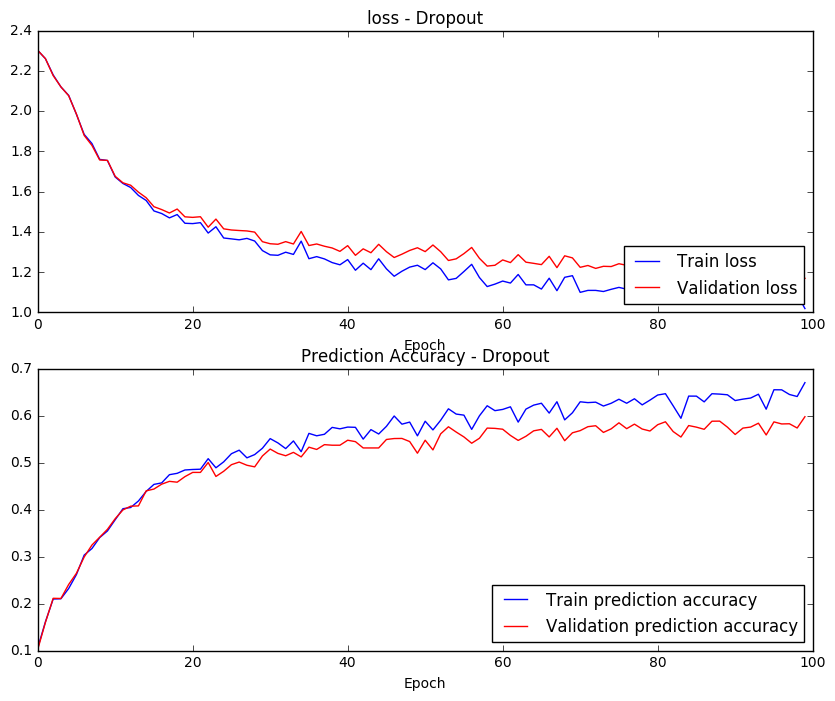

In [17]:
plt.rcParams['figure.figsize'] = (10.0, 8.0) 
plt.subplot(2,1,1)
plt.plot(loss_hist_dropout, 'b')
plt.plot(val_hist_dropout, 'r')

plt.title('loss - Dropout')
plt.xlabel('Epoch')

plt.legend(['Train loss', 'Validation loss'], loc=4)

plt.subplot(2,1,2)
plt.plot(train_pred_acc_dropout, 'b')
plt.plot(val_pred_acc_dropout, 'r')

plt.title('Prediction Accuracy - Dropout')
plt.xlabel('Epoch')

plt.legend(['Train prediction accuracy' ,'Validation prediction accuracy'], loc=4)
plt.show()

#### Save the network parameters

In [18]:
## Save network for visualization
# L5
w = network.all_params[8].eval() # Done once per notebook
w_size = np.int(np.round(np.sqrt(w.shape[0])))
w_5_dropout = w.reshape(w_size, w_size, num_classes)

# L4
w = network.all_params[6].eval() # Done once per notebook
w_4_dropout = w.reshape(w.shape[0], w.shape[1])

# L3
w = network.all_params[4].eval() # Done once per notebook
w_3_dropout = w.reshape(w.shape[0], w.shape[1])

# L2
w = network.all_params[2].eval() # Done once per notebook
w_2_dropout = w.reshape(w.shape[0], w.shape[1], w.shape[2], w.shape[3])

# L1
w = network.all_params[0].eval() # Done once per notebook
w_1_dropout = w.reshape(w.shape[0], w.shape[1], w.shape[2], w.shape[3])

In [19]:
del network

### DropConnect: 2x CNN - Feature Extractor / 2x Fully Connected Layer / 1x Softmax Layer

#### model define

In [20]:
count += 1
sess = tf.InteractiveSession()

X = tf.placeholder(tf.float32, shape=[batch_size, im_height, im_width, num_channel])
y = tf.placeholder(tf.int64, shape=[batch_size, num_classes])

network = tl.layers.InputLayer(X, name='input_layer_dropout' + str(count))
network = tl.layers.Conv2dLayer(network, act=tf.nn.relu, W_init=tf.truncated_normal_initializer(stddev=0.1),
                               shape=[patch_size, patch_size, num_channel, depth], strides=[1, 2, 2, 1],
                               padding='SAME', name='cnn_layer1_dropout' + str(count))
network = tl.layers.Conv2dLayer(network, act=tf.nn.relu, W_init=tf.truncated_normal_initializer(stddev=0.1),
                               shape=[patch_size, patch_size, depth, depth], strides=[1, 2, 2, 1],
                               padding='SAME', name='cnn_layer2_dropout' + str(count))
network = tl.layers.FlattenLayer(network, name='flatten_layer_dropout' + str(count))
network = tl.layers.DropconnectDenseLayer(network, keep=keep_prob, n_units=num_hidden1, act=tf.nn.relu, 
                              W_init=tf.truncated_normal_initializer(stddev=0.1),
                              name='dense_layer1_dropout' + str(count))
network = tl.layers.DropconnectDenseLayer(network, keep=keep_prob, n_units=num_hidden2, act=tf.nn.relu,
                              W_init=tf.truncated_normal_initializer(stddev=0.1),
                              name='dense_layer2_dropout' + str(count))
network = tl.layers.DenseLayer(network, n_units=num_classes, act=tf.identity,
                              W_init=tf.truncated_normal_initializer(stddev=0.1),
                              name='output_layer_dropout' + str(count))
pred_y = network.outputs

#compute the loss and accuracy
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred_y, labels=y))
correct_pred = tf.equal(tf.argmax(pred_y, 1), tf.argmax(y, 1))
acc = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

train_param = network.all_params
train_op = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1_adam, beta2=beta2_adam,
                                 epsilon=eps_adam, use_locking=False).minimize(loss, var_list=train_param)

  [TL] InputLayer  input_layer_dropout3: (64, 32, 32, 3)
  [TL] Conv2dLayer cnn_layer1_dropout3: shape:[5, 5, 3, 10] strides:[1, 2, 2, 1] pad:SAME act:relu
  [TL] Conv2dLayer cnn_layer2_dropout3: shape:[5, 5, 10, 10] strides:[1, 2, 2, 1] pad:SAME act:relu
  [TL] FlattenLayer flatten_layer_dropout3: 640
  [TL] DropconnectDenseLayer dense_layer1_dropout3: 256 relu
  [TL] DropconnectDenseLayer dense_layer2_dropout3: 64 relu
  [TL] DenseLayer  output_layer_dropout3: 10 identity


#### Log define

In [21]:
loss_hist_dropconnect = np.zeros(n_epoch)
train_pred_acc_dropconnect = np.zeros(n_epoch)
val_hist_dropconnect = np.zeros(n_epoch)
val_pred_acc_dropconnect = np.zeros(n_epoch)

#### Train

In [22]:
start_time = time.time()
print('Start Training at ', time.asctime(time.localtime(start_time)))
sess.run(tf.global_variables_initializer())

for epoch in range(n_epoch):
    for X_batch, y_batch in tl.iterate.minibatches(X_train, y_train, batch_size, shuffle=True):
        feed_dict = {X: X_batch, y: y_batch}
        feed_dict.update(network.all_drop)
        sess.run(train_op, feed_dict=feed_dict)
    print("Epoch %d of %d" % (epoch + 1, n_epoch))
    
    #training log
    train_loss, train_acc, n_batch = 0, 0, 0
    for X_batch, y_batch in tl.iterate.minibatches(X_train, y_train, batch_size, shuffle=True):
        dp_dict = tl.utils.dict_to_one( network.all_drop )    
        feed_dict = {X: X_batch, y: y_batch}
        feed_dict.update(dp_dict)
        loss_, acc_ = sess.run([loss, acc], feed_dict=feed_dict)
        train_loss += loss_; train_acc += acc_; n_batch += 1
    loss_hist_dropconnect[epoch] = train_loss / n_batch
    train_pred_acc_dropconnect[epoch] = train_acc / n_batch
    
    #val log
    val_loss, val_acc, n_batch = 0, 0, 0
    for X_batch, y_batch in tl.iterate.minibatches(X_val, y_val, batch_size, shuffle=True):
        dp_dict = tl.utils.dict_to_one( network.all_drop )    
        feed_dict = {X: X_batch, y: y_batch}
        feed_dict.update(dp_dict)
        loss_, acc_ = sess.run([loss, acc], feed_dict=feed_dict)
        val_loss += loss_; val_acc += acc_; n_batch += 1
    val_hist_dropconnect[epoch] = val_loss / n_batch
    val_pred_acc_dropconnect[epoch] = val_acc / n_batch
    
    #print log
    if (epoch + 1) % print_freq == 0:
        print('Training loss: %.3f' % loss_hist_dropconnect[epoch])
        print('Training accuracy: %.3f' % train_pred_acc_dropconnect[epoch])
        print('Validation loss: %.3f' % val_hist_dropconnect[epoch])
        print('Validation accuracy: %.3f' % val_pred_acc_dropconnect[epoch])

end_time = time.time()
print('Training takes: %d seconds' % (end_time - start_time))

Start Training at  Sun Feb 25 15:55:42 2018
Epoch 1 of 100
Epoch 2 of 100
Epoch 3 of 100
Epoch 4 of 100
Epoch 5 of 100
Epoch 6 of 100
Epoch 7 of 100
Epoch 8 of 100
Epoch 9 of 100
Epoch 10 of 100
Training loss: 2.299
Training accuracy: 0.102
Validation loss: 2.304
Validation accuracy: 0.101
Epoch 11 of 100
Epoch 12 of 100
Epoch 13 of 100
Epoch 14 of 100
Epoch 15 of 100
Epoch 16 of 100
Epoch 17 of 100
Epoch 18 of 100
Epoch 19 of 100
Epoch 20 of 100
Training loss: 2.291
Training accuracy: 0.111
Validation loss: 2.300
Validation accuracy: 0.106
Epoch 21 of 100
Epoch 22 of 100
Epoch 23 of 100
Epoch 24 of 100
Epoch 25 of 100
Epoch 26 of 100
Epoch 27 of 100
Epoch 28 of 100
Epoch 29 of 100
Epoch 30 of 100
Training loss: 1.634
Training accuracy: 0.403
Validation loss: 1.654
Validation accuracy: 0.391
Epoch 31 of 100
Epoch 32 of 100
Epoch 33 of 100
Epoch 34 of 100
Epoch 35 of 100
Epoch 36 of 100
Epoch 37 of 100
Epoch 38 of 100
Epoch 39 of 100
Epoch 40 of 100
Training loss: 1.346
Training accurac

#### Test

In [23]:
print('Test')

test_loss, test_acc, n_batch = 0, 0, 0
for X_batch, y_batch in tl.iterate.minibatches(X_test, y_test, batch_size, shuffle=True):
    dp_dict = tl.utils.dict_to_one( network.all_drop )    
    feed_dict = {X: X_batch, y: y_batch}
    feed_dict.update(dp_dict)
    loss_, acc_ = sess.run([loss, acc], feed_dict=feed_dict)
    test_loss += loss_; test_acc += acc_; n_batch += 1
test_loss_dropconnect = test_loss / n_batch
test_acc_dropconnect = test_acc / n_batch

print('Test loss: %.3f' % test_loss_dropconnect)
print('Test acc: %.3f' % test_acc_dropconnect)

Test
Test loss: 1.292
Test acc: 0.539


#### Plot

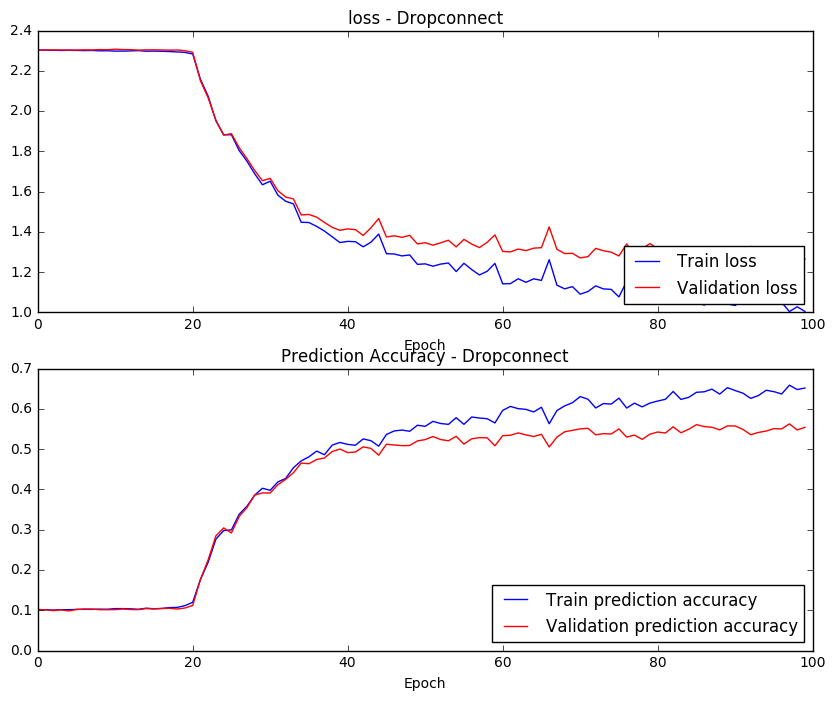

In [24]:
plt.rcParams['figure.figsize'] = (10.0, 8.0) 
plt.subplot(2,1,1)
plt.plot(loss_hist_dropconnect, 'b')
plt.plot(val_hist_dropconnect, 'r')

plt.title('loss - Dropconnect')
plt.xlabel('Epoch')

plt.legend(['Train loss', 'Validation loss'], loc=4)

plt.subplot(2,1,2)
plt.plot(train_pred_acc_dropconnect, 'b')
plt.plot(val_pred_acc_dropconnect, 'r')

plt.title('Prediction Accuracy - Dropconnect')
plt.xlabel('Epoch')

plt.legend(['Train prediction accuracy' ,'Validation prediction accuracy'], loc=4)
plt.show()

#### Save

In [25]:
## Save network for visualization
# L5
w = network.all_params[8].eval() # Done once per notebook
w_size = np.int(np.round(np.sqrt(w.shape[0])))
w_5_dropconnect = w.reshape(w_size, w_size, num_classes)

# L4
w = network.all_params[6].eval() # Done once per notebook
w_4_dropconnect = w.reshape(w.shape[0], w.shape[1])

# L3
w = network.all_params[4].eval() # Done once per notebook
w_3_dropconnect = w.reshape(w.shape[0], w.shape[1])

# L2
w = network.all_params[2].eval() # Done once per notebook
w_2_dropconnect = w.reshape(w.shape[0], w.shape[1], w.shape[2], w.shape[3])

# L1
w = network.all_params[0].eval() # Done once per notebook
w_1_dropconnect = w.reshape(w.shape[0], w.shape[1], w.shape[2], w.shape[3])

## Drop* as a Ensemble method (Shared Parameter Bagging)

#### What is Bagging?

![](https://github.com/DTennant/Regularization-test/raw/master/pic/bagging.png)

**Bagging** is a technique to reduce the Generalization error by combine the result of several models, the main idea is to train several models separately, and then use all the models to vote for the final output, which is a typical method used in machine learning contests. And it's also called *Model averaging*.
The reason why *Model averaging* will work is that different usually don't have the exactly same error on the test-set.
For example, suppose we have $k$ regression models. The error each of the models made on the test-set is $\epsilon_i$, the distribution of the error is Multi-dimensional Gaussian distribution with $\mathbb{E}[\epsilon^2_i]=v$ and $\mathbb{E}[\epsilon_i\epsilon_j]=c$. By average the result of all model's output, so the error made by the averaging is $\frac{1}{k}\sum_i\epsilon_i$. The expectation of error made by this averaging model is:
$$\mathbb{E}[(\frac{1}{k}\sum_i\epsilon_i)^2]=\frac{1}{k^2}\mathbb{E}[\sum_i(\epsilon^2_i+\sum_{j\neq{i}}\epsilon_i\epsilon_j)]=\frac{1}{k}v+\frac{k-1}{k}c$$
When the error is perfectly correlated, which is $c=v$, then the expectation is $v$, the Model averaging does not improve the result. But when the error is not perfectly correlated, which is $c=0$, the expectation will only be $\frac{1}{k}v$, this means that the expectation of error will decrease linearly as the scale of ensemable increase. This tells us that Model averaging will be at least as better as any member of the ensemble, and if the error of each member is independent, the ensemble will be much better.
To be specific, Bagging method constructs $k$ different dataset and $k$ models, the $k$ datasets are sampled with replacement from the original dataset (and have the same size). $Model_i$ is trained on $dataset_i$, and then ensemble all the models together the make predicts.

### What is Dropout?

![](https://github.com/DTennant/Regularization-test/raw/master/pic/dropout.png)

### Dropout as Bagging method

The origin Bagging cannot be used directly on deep neural networks due to the computing resources this will requires. Dropout is a technique for addressing this problem. The key idea is to randomly drop units (along with their connections) from the neural network during training as the figure above shows. 
While training, we sample a binary mask with some probability $p$, the mask vector can be defined as $mu$, the mask vector is sample independently for every layer we want to perform dropout. Then we perform the same forward pass, back propagation and parameter updates.


### Dropout as Adaptive Regularization

Working on it

### What is Dropconnect

![](https://github.com/DTennant/Regularization-test/raw/master/pic/dropconnect.png)